## Load the packages

In [1]:
# Import the packages
import hssm
import pytensor  # Graph-based tensor library
import bambi as bmb
import pandas as pd
from matplotlib import pyplot as plt
import arviz as az
import numpy as np
import pymc as pm

# Setting float precision in pytensor
pytensor.config.floatX = "float32"
pytensor.config.optimizer = 'None'
from jax.config import config
config.update("jax_enable_x64", False)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/users/igrahek/anaconda/pyHSSM/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the data

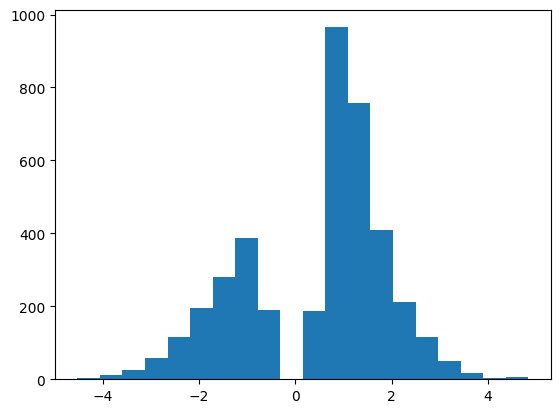

In [2]:
# Load a package-supplied dataset
data = hssm.load_data('cavanagh_theta')

# Plot the RTs
data['response'] = data['response'].replace(0, -1)
plt.hist(data['rt']*data['response'], bins=20)
plt.show()

In [3]:
data.head()

,subj_idx,stim,rt,response,theta,dbs,conf
0,0,LL,1.21,1.0,0.656275,1,HC
1,0,WL,1.63,1.0,-0.327889,1,LC
2,0,WW,1.03,1.0,-0.480285,1,HC
3,0,WL,2.77,1.0,1.927427,1,LC
4,0,WW,1.14,-1.0,-0.213236,1,HC


## Specify the model

In [4]:
# Specify the model
model = hssm.HSSM(
    model="ddm",
    loglik_kind="approx_differentiable",
    data=data,
    p_outlier={"name": "Uniform", "lower": 0.01, "upper": 0.05},
    lapse=bmb.Prior("Uniform", lower=0.0, upper=20.0),
    include=[
        {
            "name": "v",
            "prior": {
                "Intercept": {"name": "Normal", "mu": 0.0, "sigma": 1.0},
                "1|subj_idx": {"name": "Normal", "mu":0.0, "sigma":{"name": "Gamma",  "alpha": 2.0, "beta": 10.0}},
                
                "conf": {"name": "Normal", "mu": 0.0, "sigma": 0.5},
                "1|conf": {"name": "Normal", "mu":0.0, "sigma":{"name": "Gamma",  "alpha": 2.0, "beta": 10.0}},
            },
            "formula": "v ~ 1 + conf + (1 + conf|subj_idx)",
        },
        {
            "name": "a",
            "prior": {
                "Intercept": {"name": "Gamma", "alpha": 2.0, "beta": 10.0},
                "1|subj_idx": {"name": "Normal", "mu":0.0, "sigma":{"name": "Gamma",  "alpha": 2.0, "beta": 10.0}},
                
                "conf": {"name": "Normal", "mu": 0.0, "sigma": 0.2},
                "1|conf": {"name": "Normal", "mu":0.0, "sigma":{"name": "Gamma",  "alpha": 2.0, "beta": 10.0}},
            },
            "formula": "a ~ 1 + conf + (1 + conf|subj_idx)",
        },
        {
            "name": "z",
            "prior": {
                "Intercept": {"name": "Uniform", "lower": 0.1, "upper": 0.9},
                "1|subj_idx": {"name": "Normal", "mu":0.0, "sigma":{"name": "Gamma",  "alpha": 2.0, "beta": 10.0}},
                
                "conf": {"name": "Normal", "mu": 0.0, "sigma": 0.2},
                "1|conf": {"name": "Normal", "mu":0.0, "sigma":{"name": "Gamma",  "alpha": 2.0, "beta": 10.0}},
            },
            "formula": "z ~ 1 + conf + (1 + conf|subj_idx)",
        },
    ],
)

## Set the initial values for the sampler

In [5]:
# Specify the dictionary of initial values
n_subjects = len(data.subj_idx.unique())
n_subjects

# To check the shapes of all variables:
# model.pymc_model.eval_rv_shapes()

# To check the initial points (init method might changes these; 
#e.g. jitter might be added when you run the model; 
#we use init="adapt_diag" to avoid this):
# model.pymc_model.initial_point()

my_inits = {'t': 0.1,
                                  
            'v_Intercept': 0.0,
            'v_1|subj_idx_sigma': 0.01,
            'v_1|subj_idx_offset': np.zeros((n_subjects,)).astype(np.float32), # Watch out: shape=(n_subjects,)
            
            'v_conf': np.array([0.0]).astype(np.float32),
            'v_conf|subj_idx_sigma': np.array([0.01]).astype(np.float32),
            'v_conf|subj_idx_offset': np.zeros((n_subjects, 1)).astype(np.float32),
            
            'a_Intercept': 1.0,
            'a_1|subj_idx_sigma': 0.1,
            'a_1|subj_idx_offset': np.zeros((n_subjects,)).astype(np.float32), # Watch out: shape=(n_subjects,)
            
            'a_conf': np.array([0.0]).astype(np.float32),
            'a_conf|subj_idx_sigma': np.array([0.01]).astype(np.float32),
            'a_conf|subj_idx_offset': np.zeros((n_subjects, 1)).astype(np.float32),
            
            'z_Intercept': 0.5,
            'z_1|subj_idx_sigma': 0.1,
            'z_1|subj_idx_offset': np.zeros((n_subjects,)).astype(np.float32), # Watch out: shape=(n_subjects,)
            
            'z_conf': np.array([0.0]).astype(np.float32),
            'z_conf|subj_idx_sigma': np.array([0.01]).astype(np.float32),
            'z_conf|subj_idx_offset': np.zeros((n_subjects, 1)).astype(np.float32),
           }


## Fit the model

In [ ]:
# Sample
modelObject = model.sample(
    sampler="nuts_numpyro", 
    initvals = my_inits, 
    chains=4, 
    cores=4, 
    draws=200, 
    tune=200,
    #target_accept=0.95
)

Compiling...


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Compilation time =  0:00:06.199464
Sampling...


/users/igrahek/anaconda/pyHSSM/lib/python3.11/site-packages/pytensor/link/jax/dispatch/scalar.py:135: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jnp.array(x).astype(op.o_type.dtype)
/users/igrahek/anaconda/pyHSSM/lib/python3.11/site-packages/pytensor/link/jax/dispatch/elemwise.py:35: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jax_op(x, axis=axis).astype(acc_dtype)
/users/igrahek/anaconda/pyHSSM/lib/python3.11/site-packages/pytensor/link/jax/dispatch/tensor_b

## Analyze the posterior

In [ ]:
# PLot the traces
az.rcParams["plot.max_subplots"] = 38
az.plot_trace(modelObject)
plt.tight_layout()
plt.show()

In [ ]:
# Parameter estimates
pd.set_option('display.max_rows', 500)
az.summary(modelObject, var_names=['~a','~t', '~z'])


In [ ]:
# Posterior pair plot
az.plot_pair(modelObject, kind="kde")


In [ ]:
modelObject["posterior.a_Intercept"] = np.exp(modelObject.posterior.a_Intercept)